In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from main import create_packets, sort_packets, Packet, PacketOutput, LCFS_S, LCFS_W, ProposedPolicy, get_outputs_by_source, calculate_average_age_information, get_age_of_information_updates

In [2]:
POLICIES = [
    ("proposed_policy", ProposedPolicy()),
    ("lcfs_s", LCFS_S()),
    ("lcfs_w", LCFS_W())
]

In [3]:
def fig2(p: float, p0_min: float, p0_max: float, p0_step: float, time: float, ylim=None):
    service_time_mean = 1
    p0 = p0_min

    data = {
        policy_name: [] for policy_name, _ in POLICIES
    }

    while p0 <= p0_max:
        p1 = p - p0
        
        packets = sort_packets(
            create_packets(max_arrival_time=time, source=0, arrival_rate=p0, service_time_mean=1, seed=0), 
            create_packets(max_arrival_time=time, source=1, arrival_rate=p1, service_time_mean=1, seed=1),
        )
            
        for policy_name, policy in POLICIES:
            outputs = policy.simulate(packets)
            s0_aoi = calculate_average_age_information(outputs, source=0)
            s1_aoi = calculate_average_age_information(outputs, source=1)
   
            sum_aoi = s0_aoi + s1_aoi

            data[policy_name].append((p0, sum_aoi))
        

        p0 += p0_step

    for policy_name, points in data.items():
        plt.plot([x for x, _ in points], [y for _, y in points], label=f'{policy_name}', marker='o', markersize=3)

    plt.title(f'p={p}')

    plt.xlabel('p0')
    plt.ylim(ylim)
    plt.ylabel('Sum Average AoI')
    plt.legend()
    plt.show()

    return data

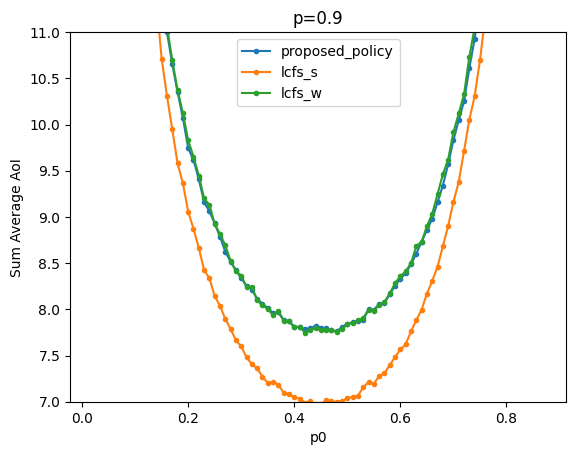

In [4]:
data = fig2(p=0.9, p0_min=0.02, p0_max=0.88, p0_step=0.01, time=25_000, ylim=(7, 11))

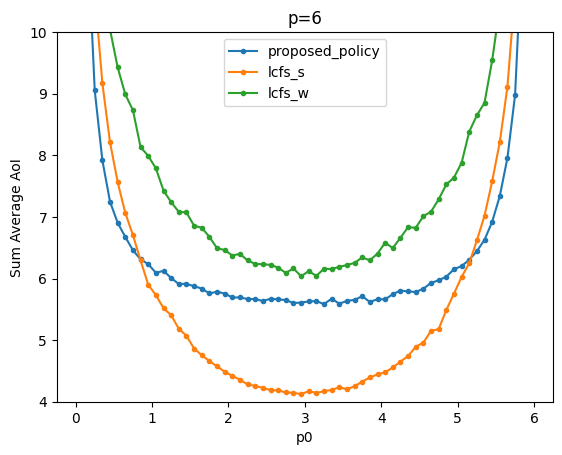

In [5]:
data = fig2(p=6, p0_min=0.05, p0_max=5.95, p0_step=0.1, time=25_000, ylim=(4, 10))

In [13]:
def plot_age_of_information(outputs: list[PacketOutput], sources: list[int], plot_average=False):
    colors = ['r', 'b']
    max_time = max(output.service_end_time for output in outputs)

    sum_avg = 0
    
    for source in sources:
        updates = get_age_of_information_updates(outputs, source)
        
        if len(updates) < 1:
            continue
        
        plt.plot([x for x, _ in updates], [y for _, y in updates], label=f'source {source}', c=colors[source], alpha=1)
        
        if plot_average:
            avg = calculate_average_age_information(outputs, source)
            sum_avg += avg
            plt.plot((0, max_time), (avg, avg), label=f'source {source} avg', c=colors[source], alpha=0.5)
            

    plt.title('age of information vs. time')
    plt.xlabel('time')
    plt.ylabel('age of information')
    plt.legend()
    plt.show()
    return sum_avg

In [29]:
packets = sort_packets(
    create_packets(max_arrival_time=100, source=0, arrival_rate=0.1, service_time_mean=1), 
    create_packets(max_arrival_time=100, source=1, arrival_rate=0.80, service_time_mean=1),
)

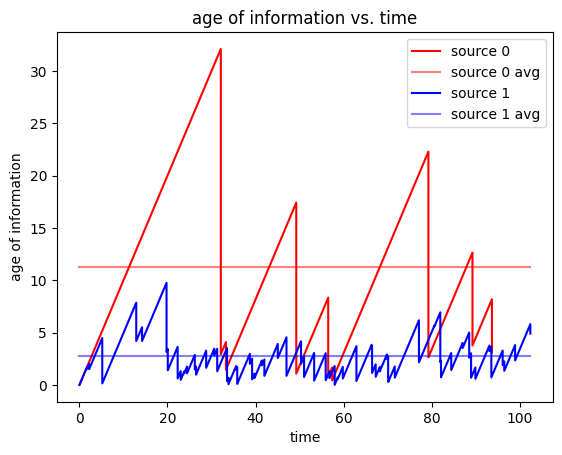

14.061867754009496

In [30]:
outputs = LCFS_W().simulate(packets)
plot_age_of_information(outputs, sources=[0, 1], plot_average=True)

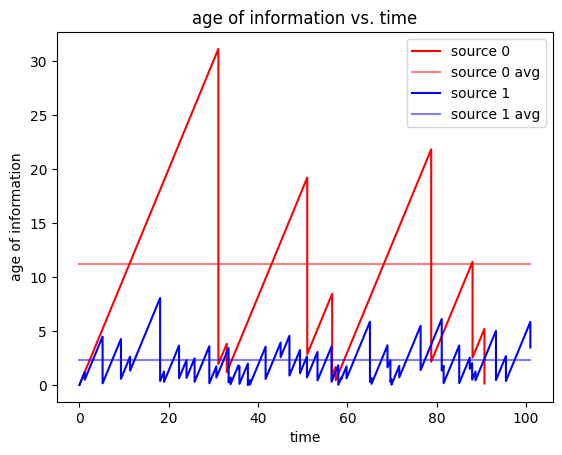

13.494878017933646

In [31]:
outputs = LCFS_S().simulate(packets)
plot_age_of_information(outputs, sources=[0, 1], plot_average=True)

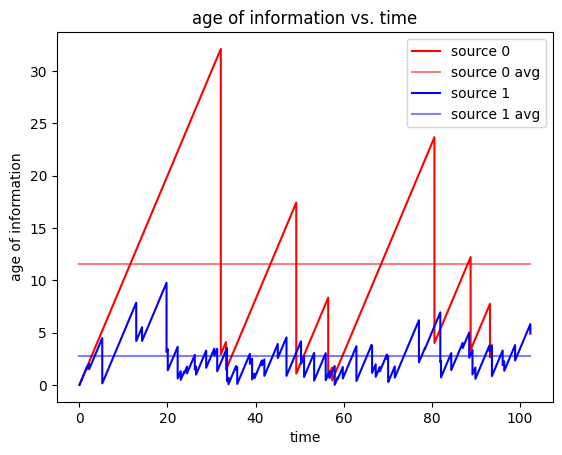

14.336038569076226

In [32]:
outputs = ProposedPolicy().simulate(packets)
plot_age_of_information(outputs, sources=[0, 1], plot_average=True)

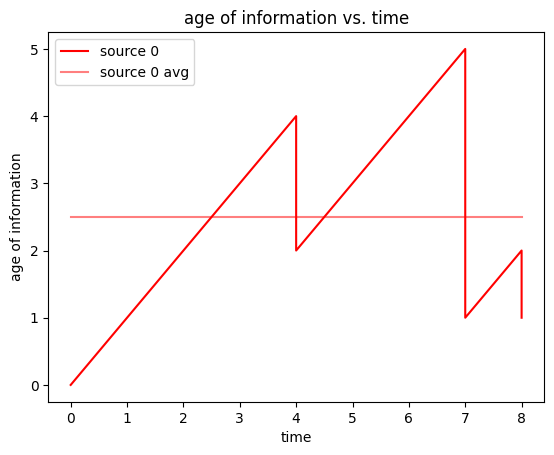

[AoiUpdate(time=0, age=0),
 AoiUpdate(time=4, age=4),
 AoiUpdate(time=4, age=2),
 AoiUpdate(time=7, age=5),
 AoiUpdate(time=7, age=1),
 AoiUpdate(time=8, age=2),
 AoiUpdate(time=8, age=1)]

In [33]:
dummy_output = [
    PacketOutput(source=0, arrival_time=2, service_end_time=4),
    PacketOutput(source=0, arrival_time=6, service_end_time=7),
    PacketOutput(source=0, arrival_time=7, service_end_time=8),
]
plot_age_of_information(dummy_output, sources=[0], 
    plot_average=True)

updates = get_age_of_information_updates(dummy_output, source=0)
updates

In [7]:
import pandas as pd

pd.DataFrame(outputs).to_csv('./output.csv')
